In [1]:
%reset
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.ticker as mticker
import warnings; warnings.filterwarnings('ignore')
import cmocean
from xgcm import Grid
#import gcm_filters

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [ ]:
## Reading in data for 1/2 degree parameterized runs:

In [2]:
#Unparameterized 1/2 degree run:
%cd /glade/p/univ/unyu0004/eyankovsky/MEKE_testing/default_noparameterization
fs = xr.open_dataset('static.nc', decode_times=False)
av=xr.open_dataset('averages_00031502.nc',decode_times=False)


#Contains default setup based on Jansen et al 2019. MEKE_VISCOSITY_COEFF_KU = -0.15; MEKE_KHCOEFF = 0.15
%cd /glade/p/univ/unyu0004/eyankovsky/MEKE_testing/MEKE_GM_BS_default/
av_05_GMBS = xr.open_dataset('averages_00031502.nc', decode_times=False)  

#CBS=-1
%cd /glade/scratch/eyankovsky/Backscatter_tests_with_Scott/Finalized_Runs/Malte_EBTpower2_0.5deg
av_BS_new = xr.open_dataset('averages_00031502.nc', decode_times=False)  

%cd /glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis/



/glade/p/univ/unyu0004/eyankovsky/MEKE_testing/default_noparameterization
/glade/p/univ/unyu0004/eyankovsky/MEKE_testing/MEKE_GM_BS_default
/glade/scratch/eyankovsky/Backscatter_tests_with_Scott/Finalized_Runs/Malte_EBTpower2_0.5deg
/glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis


In [3]:
%%time
xh = fs.xh.values
yh = fs.yh.values
# #COMPUTE velocity components for decomposing KE:
Nlayers=15

grid= Grid(av, coords={'X': {'center': 'xh', 'outer': 'xq'}, #This tells the grid where xh, xq, yh, and yq are defined.
                        'Y': {'center': 'yh', 'outer': 'yq'}});


SSU = av['SSU']
SSV = av['SSV']
SSU = grid.interp(SSU,axis='X'); SSV = grid.interp(SSV,axis='Y')
SKE_05 = (0.5*(SSU**2+SSV**2))


SSU = av_05_GMBS['SSU']
SSV = av_05_GMBS['SSV']
SSU = grid.interp(SSU,axis='X'); SSV = grid.interp(SSV,axis='Y')
SKE_05_GMBS = (0.5*(SSU**2+SSV**2))

SSU = av_BS_new['SSU']
SSV = av_BS_new['SSV']
SSU = grid.interp(SSU,axis='X'); SSV = grid.interp(SSV,axis='Y')
SKE_BS_new = (0.5*(SSU**2+SSV**2))

CPU times: user 375 ms, sys: 1.81 s, total: 2.18 s
Wall time: 8.83 s


## Reading in data for 1/32 with no eddy parameterization:

In [14]:
%cd /glade/p/univ/unyu0004/gmarques/NeverWorld2/baselines/nw2_0.03125deg_N15_baseline_hmix5/
%ls
fs_hr = xr.open_dataset('static.nc', decode_times=False)
av_hr = xr.open_mfdataset(['averages_00002302.nc','averages_00002402.nc','averages_00002502.nc','averages_00002602.nc','averages_00002702.nc'], decode_times=False)
%cd /glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis/

/glade/campaign/univ/unyu0004/NeverWorld2/nw2_0.03125deg_N15_baseline_hmix5
available_diags.000000  longmean_00002050.nc         sub01/
averages_00002002.nc    longmean_00002150.nc         sub02/
averages_00002102.nc    longmean_00002250.nc         sub03/
averages_00002202.nc    longmean_00002350.nc         sub04/
averages_00002302.nc    longmean_00002450.nc         sub04_sfc/
averages_00002402.nc    longmean_00002550.nc         sub05/
averages_00002502.nc    longmean_00002650.nc         sub05_sfc/
averages_00002602.nc    longmean_00002750.nc         sub06/
averages_00002702.nc    MOM_IC_1.nc                  sub06_sfc/
CPU_stats               MOM_IC_2.nc                  sub07/
diag_table@             MOM_IC.nc                    sub07_sfc/
diag_table.final        MOM_input@                   sub08/
diag_table.init         MOM_layout@                  sub08_sfc/
diag_table.sfc          MOM_override                 sub09/
exitcode                MOM_parameter_doc.all        sub10/
INPU

In [15]:
%%time
xh_hr = fs_hr.xh.values
yh_hr = fs_hr.yh.values
# #COMPUTE velocity components for decomposing KE:
Nlayers=15

cfac=8 #coarsening factor to put data onto a 1/2 degree grid.
grid= Grid(av_hr, coords={'X': {'center': 'xh', 'outer': 'xq'}, #This tells the grid where xh, xq, yh, and yq are defined.
                        'Y': {'center': 'yh', 'outer': 'yq'}});


SSU = av_hr['SSU']
SSV = av_hr['SSV']
grid= Grid(av_hr, coords={'X': {'center': 'xh', 'outer': 'xq'}, #This tells the grid where xh, xq, yh, and yq are defined.
                        'Y': {'center': 'yh', 'outer': 'yq'}});
SSU = grid.interp(SSU,axis='X').coarsen(xh=cfac,yh=cfac, boundary="exact").mean()
SSV = grid.interp(SSV,axis='Y').coarsen(xh=cfac,yh=cfac, boundary="exact").mean()

SKE_HR = (0.5*(SSU**2+SSV**2))



CPU times: user 18.2 ms, sys: 1.19 ms, total: 19.4 ms
Wall time: 18.5 ms


In [16]:
SSU.shape

(100, 560, 240)

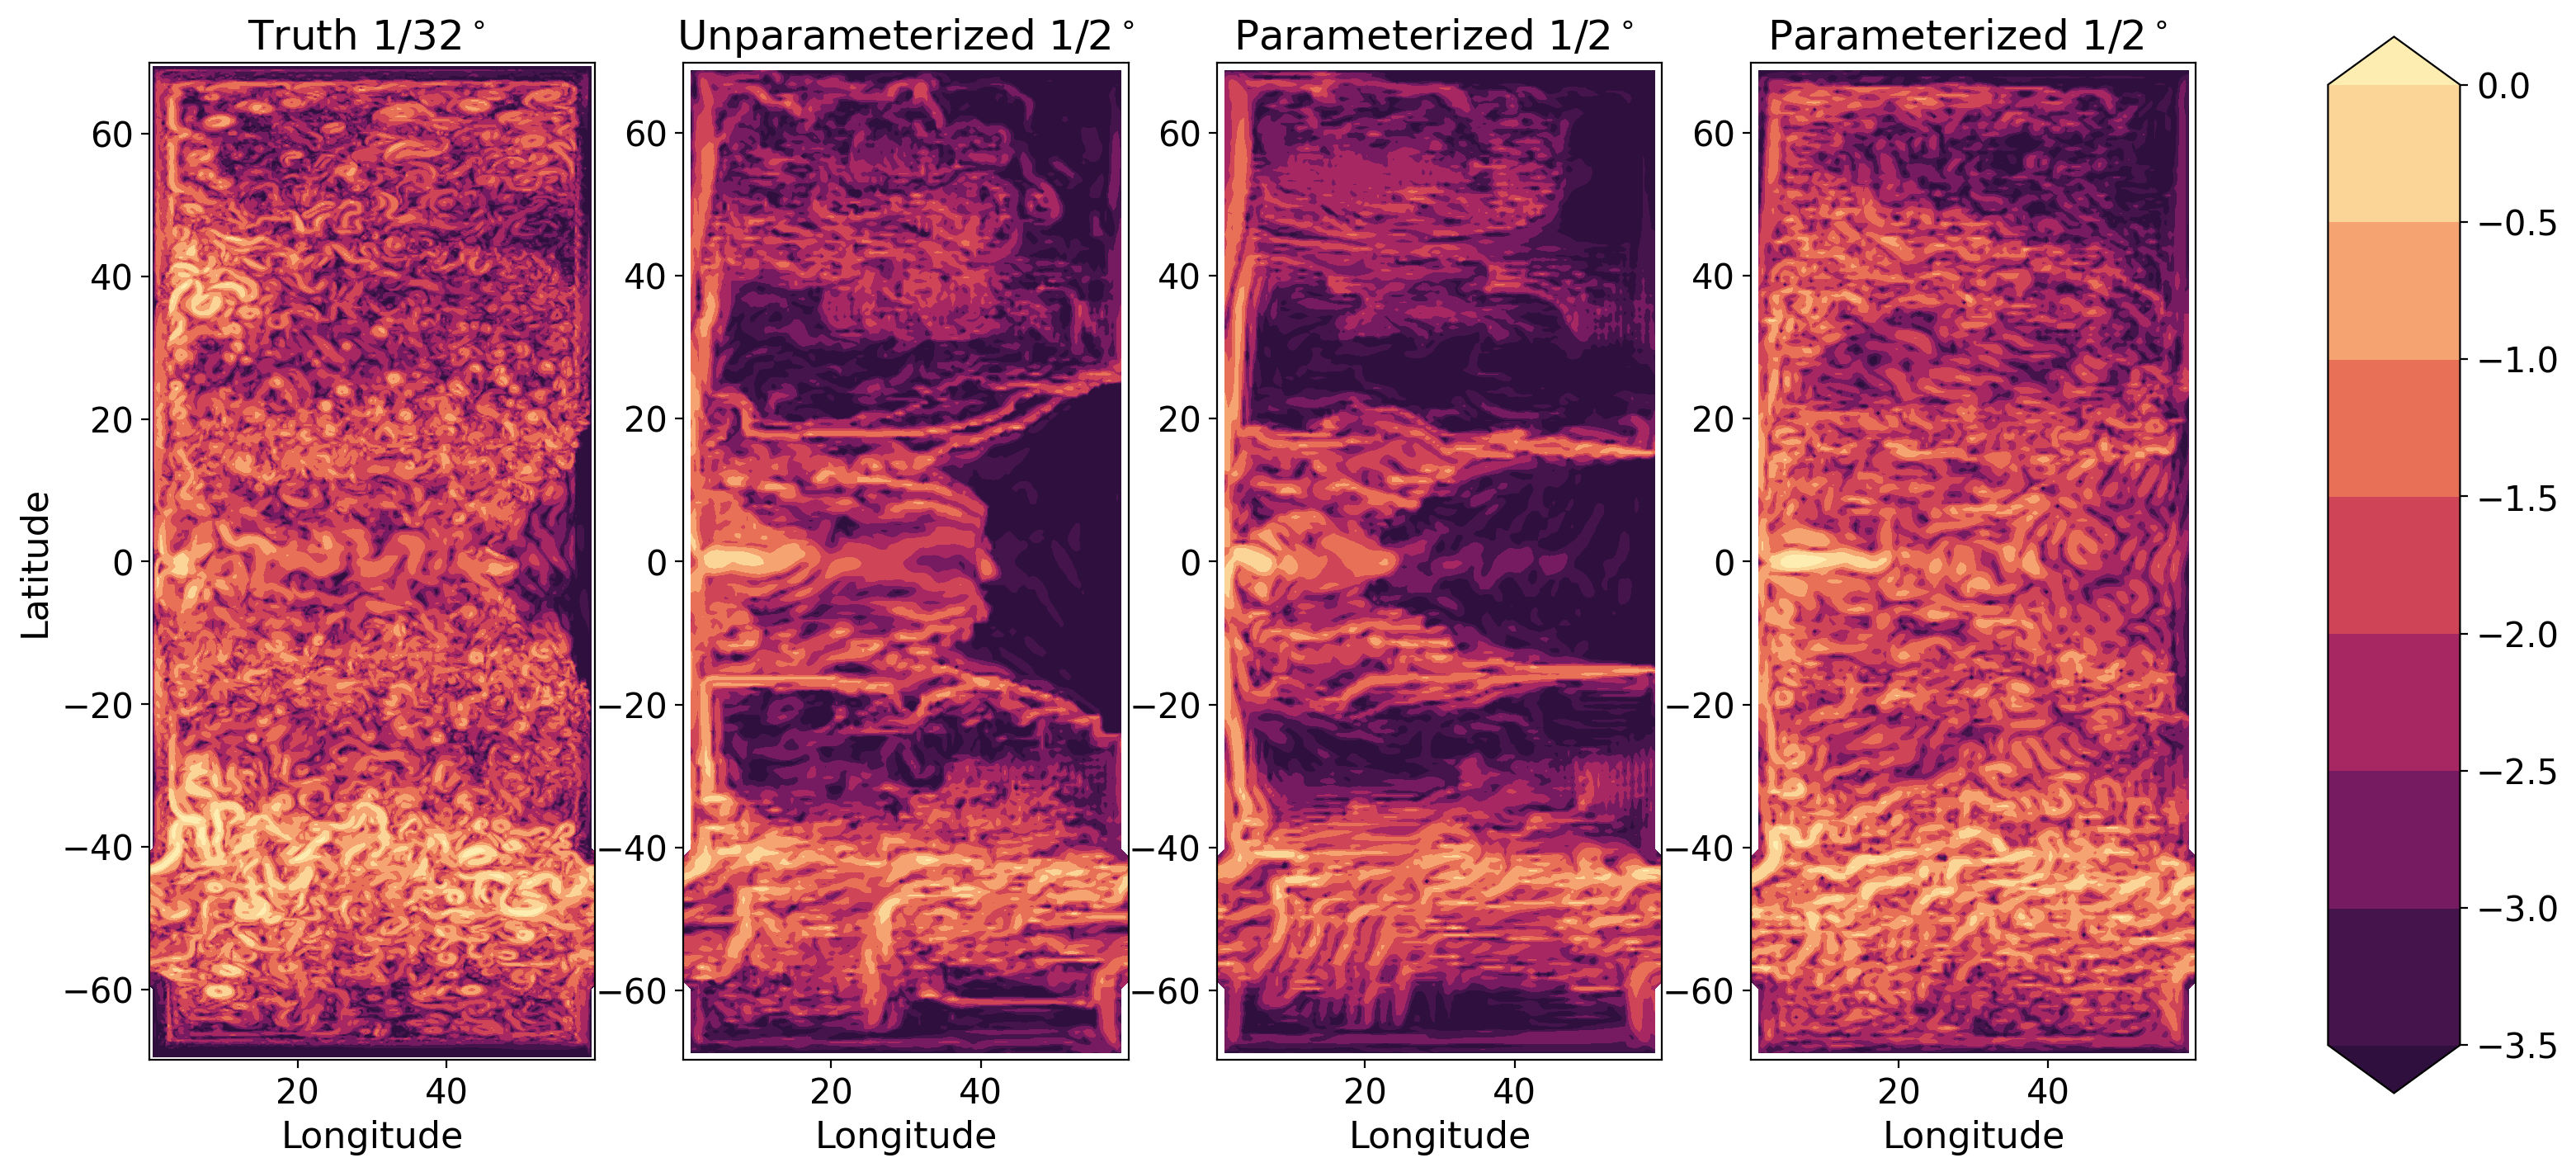

<Figure size 432x288 with 0 Axes>

In [17]:
#For the convolution window use N=240 for 1/32 deg.; N=120 for 1/16deg.; N=60 for 1/8deg.; and N=30 for 1/4deg.
%pwd
fig,ax=plt.subplots(4,figsize=(16, 8), facecolor='w', edgecolor='k',subplot_kw=dict(box_aspect=1),dpi=200)
#plt.tick_params(axis='both', which='major', labelsize=26)

plt.rc('xtick',labelsize=15)
plt.rc('ytick', labelsize=15)
levels=np.linspace(-3.5,0,8)

plt.subplot(1,4,1)
im =plt.contourf(SKE_HR.xh,SKE_HR.yh,np.log10(SKE_HR[0,:]),levels=levels,cmap=cmocean.cm.matter_r,extend='both')
plt.title('Truth 1/32$^\circ$ ',fontsize=18)
plt.xlabel('Longitude',fontsize=16)
plt.ylabel('Latitude',fontsize=16)


plt.subplot(1,4,2)
plt.contourf(xh,yh,np.log10(SKE_05[0,:]),levels=levels,cmap=cmocean.cm.matter_r,extend='both')
plt.title('Unparameterized 1/2$^\circ$',fontsize=18)
plt.xlabel('Longitude',fontsize=16)



plt.subplot(1,4,3)
plt.contourf(xh,yh,np.log10(SKE_05_GMBS[0,:]),levels=levels,cmap=cmocean.cm.matter_r,extend='both')
plt.title('Parameterized 1/2$^\circ$ ',fontsize=18)
plt.xlabel('Longitude',fontsize=16)

plt.subplot(1,4,4)
plt.contourf(xh,yh,np.log10(SKE_BS_new[0,:]),levels=levels,cmap=cmocean.cm.matter_r,extend='both')
plt.title('Parameterized 1/2$^\circ$ ',fontsize=18)
plt.xlabel('Longitude',fontsize=16)

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.10, 0.05, 0.8])
fig.colorbar(im, cax=cbar_ax)
plt.show()

 
plt.tight_layout()


In [8]:
# fig = plt.figure(figsize=(4, 8), facecolor='w', edgecolor='k',dpi=150)
# #ax1 = fig.add_axes([0.15,0.1,0.7,0.7])  #left pos. bottom pos. width, height #ax1 = fig.add_subplot(111)
# #ax2 = fig.add_axes([.87, 0.1, 0.05, 0.7])
# levels=np.linspace(-3.5,0,8)


# #ax1.set_xlabel('Latitude',fontsize=16); ax1.set_ylabel('Longitude',fontsize=16)
# #ax1.tick_params(labelsize=16); ax2.tick_params(labelsize=10);

# for i in range(0,1):
#     SKE_HR = (0.5*(SSU[i,]**2+SSV[i,:]**2))
#     im =plt.contourf(SKE_HR.xh,SKE_HR.yh,np.log10(SKE_HR),levels=levels,cmap=cmocean.cm.matter_r,extend='both') 
#     plt.gca().set_aspect('equal')
#     cbar_ax = fig.add_axes([0.95, 0.10, 0.05, 0.8])
#     fig.colorbar(im, cax=cbar_ax)
#  #   cb1 = fig.colorbar(im,ax2)
#  #   plt.tight_layout()
    
#     plt.savefig('index%.3d'%i)

/glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis/movies


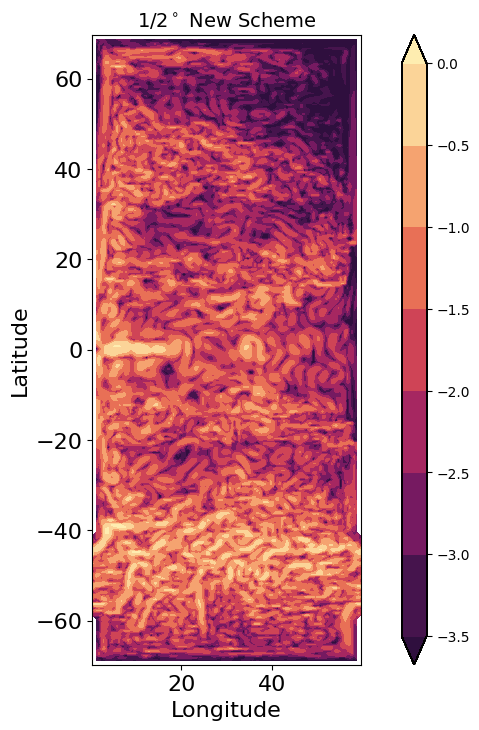

In [6]:
#%rm *.png
%cd /glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis/movies
%rm *.png
fig = plt.figure(figsize=(5, 9), dpi= 100, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.25,0.1,0.6,0.7])  #left pos. bottom pos. width, height #ax1 = fig.add_subplot(111)
ax2 = fig.add_axes([.9, 0.1, 0.05, 0.7])

ax1.set_xlabel('Longitude',fontsize=16); ax1.set_ylabel('Latitude',fontsize=16)
ax1.tick_params(labelsize=16); ax2.tick_params(labelsize=10);
levels=np.linspace(-3.5,0,8)

for i in range(0,100):
    
    im = ax1.contourf(SKE_BS_new.xh,SKE_BS_new.yh,np.log10(SKE_BS_new[i,:]),levels=levels,cmap=cmocean.cm.matter_r,extend='both')
    cb1 = fig.colorbar(im,ax2)
    #quad1 = ax1.pcolormesh(xq/1000,zl,wi,cmap='RdBu_r',vmin=-.002,vmax=.002,shading='goaround')
    #cb1 = fig.colorbar(quad1,ax2,format='%.3e')
    ax1.set_aspect('equal')

    ax1.set_title('1/2$^\circ$ New Scheme', fontsize=14)
    #ax2.set_title('log(EKE)', fontsize=14)
    plt.savefig('index%.3d'%i,bbox_inches='tight')

In [9]:
%pwd

'/glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis'